In [1]:
import tensorflow as tf

# Enable GPU growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


import numpy as np
from matplotlib import pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Flatten, Dropout, Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.callbacks import LearningRateScheduler


Mounted at /content/drive


In [22]:
def reshape_data(arr):
    input_data = arr
    """indexes_to_delete = [2, 3, 4, 5, 12, 13, 14, 15, 16, 17]
    output_data = np.empty((arr.shape[0], 5, 8, 2, 24))  # Create an empty array with the desired shape

    for i, video_data in enumerate(input_data):
        print(video_data.shape)
        video_data = np.delete(video_data, indexes_to_delete, axis=1)
        print(video_data.shape)
        output_data[i] = video_data"""

    output_data = input_data

    batchsize, _, _, _, _ = output_data.shape
    reshaped_arr = np.reshape(output_data, (batchsize, 24, 180))

    normalized_data = (reshaped_arr - np.mean(reshaped_arr)) / np.std(reshaped_arr)


    return normalized_data


def preprocess_datasets(dataset_vars, split_amount):
    reshaped_data = []
    numerical_labels = []

    for var_names in dataset_vars:
        # Load dataset
        pose_keypoints_list = var_names[0]
        labels_list = var_names[1]

        # Reshape data
        reshaped_data.append(reshape_data(pose_keypoints_list))

        # Convert labels to numerical values
        numerical_labels.append(np.array([label_mapping[label] for label in labels_list]))

    # Concatenate all the data
    X = tf.convert_to_tensor(np.concatenate(reshaped_data, axis=0), dtype=tf.float32)
    y = tf.keras.utils.to_categorical(np.concatenate(numerical_labels))

    # Shuffle the data
    indices = np.random.permutation(len(X))
    indices_tensor = tf.convert_to_tensor(indices, dtype=tf.int32)
    X = tf.gather(X, indices_tensor)
    y = tf.gather(y, indices_tensor)

    # Split data into training and validation sets
    train_size = int(split_amount * len(X))
    val_size = len(X) - train_size

    X_train, X_val = X[:train_size], X[train_size:]
    y_train, y_val = y[:train_size], y[train_size:]

    return X_train, X_val, y_train, y_val

pose_keypoints_test = np.load('/content/drive/MyDrive/ModelFiles/Posenet/skeleton_data_posenet.npy', allow_pickle=True) # first nao set
labels_list_test = np.load('/content/drive/MyDrive/ModelFiles/Posenet/labels_posenet.npy', allow_pickle=True)

for i, item in enumerate(labels_list_test):
    if item == 'corner-kick-red':
        labels_list_test[i] = 'Corner-kick Red'
    elif item == 'corner-kick-blue':
        labels_list_test[i] = 'Corner-kick Blue'
    elif item == 'goal-red':
        labels_list_test[i] = 'Goal Red'
    elif item == 'goal-blue':
        labels_list_test[i] = 'Goal Blue'
    elif item == 'goal-kick-red':
        labels_list_test[i] = 'Goal-kick Red'
    elif item == 'goal-kick-blue':
        labels_list_test[i] = 'Goal-kick Blue'
    elif item == 'kick-in-red':
        labels_list_test[i] = 'Kick-in Red'
    elif item == 'kick-in-blue':
        labels_list_test[i] = 'Kick-in Blue'
    elif item == 'player-exchange-red':
        labels_list_test[i] = 'Player exchange Red'
    elif item == 'player-exchange-blue':
        labels_list_test[i] = 'Player exchange Blue'
    elif item == 'pushing-free-kick-red':
        labels_list_test[i] = 'Pushing Free-kick Red'
    elif item == 'pushing-free-kick-blue':
        labels_list_test[i] = 'Pushing Free-kick Blue'
    elif item == 'full-time':
        labels_list_test[i] = 'Fulltime'


pose_keypoints_nao1 = np.load('/content/drive/MyDrive/ModelFiles/Posenet/skeleton_data_valinao.npy') #second nao set
labels_list_nao1 = np.load('/content/drive/MyDrive/ModelFiles/Posenet/labels_posenet_valinao.npy')

for i, item in enumerate(labels_list_nao1):
    if item == 'corner-kick-red':
        labels_list_nao1[i] = 'Corner-kick Red'
    elif item == 'corner-kick-blue':
        labels_list_nao1[i] = 'Corner-kick Blue'
    elif item == 'goal-red':
        labels_list_nao1[i] = 'Goal Red'
    elif item == 'goal-blue':
        labels_list_nao1[i] = 'Goal Blue'
    elif item == 'goal-kick-red':
        labels_list_nao1[i] = 'Goal-kick Red'
    elif item == 'goal-kick-blue':
        labels_list_nao1[i] = 'Goal-kick Blue'
    elif item == 'kick-in-red':
        labels_list_nao1[i] = 'Kick-in Red'
    elif item == 'kick-in-blue':
        labels_list_nao1[i] = 'Kick-in Blue'
    elif item == 'player-exchange-red':
        labels_list_nao1[i] = 'Player exchange Red'
    elif item == 'player-exchange-blue':
        labels_list_nao1[i] = 'Player exchange Blue'
    elif item == 'pushing-free-kick-red':
        labels_list_nao1[i] = 'Pushing Free-kick Red'
    elif item == 'pushing-free-kick-blue':
        labels_list_nao1[i] = 'Pushing Free-kick Blue'
    elif item == 'full-time':
        labels_list_nao1[i] = 'Fulltime'

pose_keypoints_2 = np.load('/content/drive/MyDrive/ModelFiles/Posenet/skeleton_data_posenet_ref_all.npy', allow_pickle=True) #synthetic
labels_list_2 = np.load('/content/drive/MyDrive/ModelFiles/Posenet/labels_posenet_ref_all.npy', allow_pickle=True)

for i, item in enumerate(labels_list_2):
    if item == 'Goal_Blue':
        labels_list_2[i] = 'Goal Blue'
    elif item == 'Goal_Red':
      labels_list_2[i] = 'Goal Red'
    elif item == 'Kick_In_Blue':
      labels_list_2[i] = 'Kick-in Blue'
    elif item == 'Kick_In_Red':
      labels_list_2[i] = 'Kick-in Red'
    elif item == 'Pushing_Free_Kick_Blue':
      labels_list_2[i] = 'Pushing Free-kick Blue'
    elif item == 'Pushing_Free_Kick_Red':
      labels_list_2[i] = 'Pushing Free-kick Red'
    elif item == 'Goal_Kick_Red':
      labels_list_2[i] = 'Goal-kick Red'
    elif item == 'Goal_Kick_Blue':
      labels_list_2[i] = 'Goal-kick Blue'
    elif item == 'Corner_Kick_Red':
      labels_list_2[i] = 'Corner-kick Red'
    elif item == 'Corner_Kick_Blue':
      labels_list_2[i] = 'Corner-kick Blue'
    elif item == 'Player_Exchange_Red':
      labels_list_2[i] = 'Player exchange Red'
    elif item == 'Player_Exchange_Blue':
      labels_list_2[i] = 'Player exchange Blue'
    elif item == 'Full_Time_mcp':
      labels_list_2[i] = 'Fulltime'

pose_keypoints_5 = np.load('/content/drive/MyDrive/ModelFiles/Posenet/skeleton_data_posenet_ref.npy', allow_pickle=True) #synthetic but only 250
labels_list_5 = np.load('/content/drive/MyDrive/ModelFiles/Posenet/labels_posenet_ref.npy', allow_pickle=True)
for i, item in enumerate(labels_list_5):
    if item == 'Goal_Blue':
        labels_list_5[i] = 'Goal Blue'
    elif item == 'Goal_Red':
      labels_list_5[i] = 'Goal Red'
    elif item == 'Kick_In_Blue':
      labels_list_5[i] = 'Kick-in Blue'
    elif item == 'Kick_In_Red':
      labels_list_5[i] = 'Kick-in Red'
    elif item == 'Pushing_Free_Kick_Blue':
      labels_list_5[i] = 'Pushing Free-kick Blue'
    elif item == 'Pushing_Free_Kick_Red':
      labels_list_5[i] = 'Pushing Free-kick Red'
    elif item == 'Goal_Kick_Red':
      labels_list_5[i] = 'Goal-kick Red'
    elif item == 'Goal_Kick_Blue':
      labels_list_5[i] = 'Goal-kick Blue'
    elif item == 'Corner_Kick_Red':
      labels_list_5[i] = 'Corner-kick Red'
    elif item == 'Corner_Kick_Blue':
      labels_list_5[i] = 'Corner-kick Blue'
    elif item == 'Player_Exchange_Red':
      labels_list_5[i] = 'Player exchange Red'
    elif item == 'Player_Exchange_Blue':
      labels_list_5[i] = 'Player exchange Blue'
    elif item == 'Full_Time_mcp':
      labels_list_5[i] = 'Fulltime'


pose_keypoints_3 = np.load('/content/drive/MyDrive/ModelFiles/Posenet/skeleton_data_files.npy', allow_pickle=True) #phone
labels_list_3 = np.load('/content/drive/MyDrive/ModelFiles/Posenet/labels_posenet_files.npy', allow_pickle=True)


pose_keypoints_4 = np.load('/content/drive/MyDrive/ModelFiles/Posenet/skeleton_data_filesflip.npy', allow_pickle=True) #phone flipped
labels_list_4 = np.load('/content/drive/MyDrive/ModelFiles/Posenet/labels_posenet_filesflip.npy', allow_pickle=True)


# define label_mapping once based on first dataset!!! important :)
label_mapping = {label: i for i, label in enumerate(set(labels_list_test))}




dataset_vars = [
    [pose_keypoints_test,
     labels_list_test],
    [pose_keypoints_3,
     labels_list_3]
    ,[pose_keypoints_4,
     labels_list_4],
]


split_amount = 0.8
X_train, X_val, y_train, y_val = preprocess_datasets(dataset_vars, split_amount)
print(X_train)



tf.Tensor(
[[[ 0.22136053  0.22136053  0.22136053 ...  0.7766097   0.7766097
    0.7766097 ]
  [ 0.7766097   0.7766097   0.7766097  ...  1.8315831   1.7760582
    1.7760582 ]
  [ 1.8871081   1.8871081   1.8871081  ...  1.8315831   1.7760582
    1.8315831 ]
  ...
  [-0.44493845 -0.44493845 -0.44493845 ... -0.44493845 -0.44493845
   -0.44493845]
  [-0.44493845 -0.44493845 -0.44493845 ... -0.44493845 -0.44493845
   -0.44493845]
  [-0.44493845 -0.44493845 -0.44493845 ... -0.44493845 -0.44493845
   -0.44493845]]

 [[ 1.3873838   1.3873838   1.4429088  ...  1.6650084   1.6650084
    1.7205333 ]
  [ 1.7205333   1.7205333   1.7205333  ...  1.8871081   1.8315831
    1.8871081 ]
  [ 2.4423573   2.4978821   2.608932   ...  2.4978821   2.4978821
    2.4978821 ]
  ...
  [-0.44493845 -0.44493845 -0.44493845 ... -0.44493845 -0.44493845
   -0.44493845]
  [-0.44493845 -0.44493845 -0.44493845 ... -0.44493845 -0.44493845
   -0.44493845]
  [-0.44493845 -0.44493845 -0.44493845 ... -0.44493845 -0.44493845
 

Epoch 1/1000
2/2 [==============================] - 5s 795ms/step - loss: 2.5852 - accuracy: 0.0769 - val_loss: 2.5571 - val_accuracy: 0.0914 - lr: 0.0010
Epoch 2/1000
2/2 [==============================] - 0s 43ms/step - loss: 2.5556 - accuracy: 0.1026 - val_loss: 2.5675 - val_accuracy: 0.0806 - lr: 0.0010
Epoch 3/1000
2/2 [==============================] - 0s 42ms/step - loss: 2.5432 - accuracy: 0.1080 - val_loss: 2.5709 - val_accuracy: 0.0914 - lr: 0.0010
Epoch 4/1000
2/2 [==============================] - 0s 41ms/step - loss: 2.5262 - accuracy: 0.1444 - val_loss: 2.5481 - val_accuracy: 0.1129 - lr: 0.0010
Epoch 5/1000
2/2 [==============================] - 0s 42ms/step - loss: 2.4990 - accuracy: 0.1930 - val_loss: 2.5229 - val_accuracy: 0.1720 - lr: 0.0010
Epoch 6/1000
2/2 [==============================] - 0s 44ms/step - loss: 2.4792 - accuracy: 0.1957 - val_loss: 2.5101 - val_accuracy: 0.1935 - lr: 0.0010
Epoch 7/1000
2/2 [==============================] - 0s 43ms/step - loss: 2.

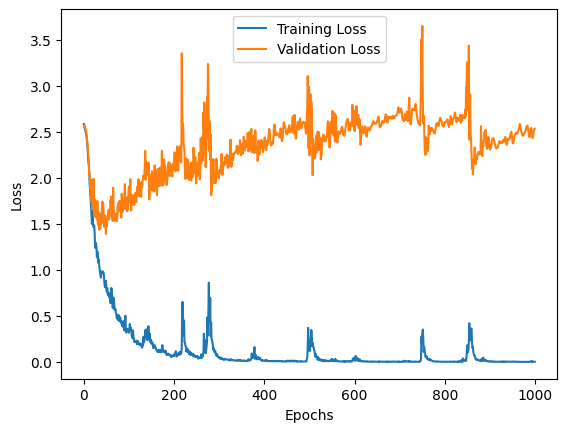

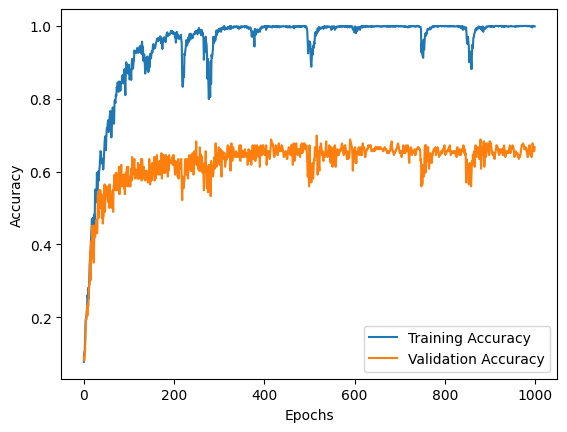

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Flatten, Dense, BatchNormalization

model = Sequential()
model.add(LSTM(units=64, input_shape=(24, 180), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=len(label_mapping), activation='softmax'))

# Define the initial learning rate and the function to update it
initial_learning_rate = 0.8

def learning_rate_scheduler(epoch, learning_rate):
    factor = 1
    if epoch == 100 * factor:  # Adjust this epoch threshold as per your needs
        factor += 1
        return learning_rate * 0.8  # Reduce the learning rate
    return learning_rate

# Compile the model with initial learning rate
optimizer = tf.keras.optimizers.Adam(lr=initial_learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(learning_rate_scheduler)

# Fit the model with the learning rate scheduler callback
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, batch_size=512, callbacks=[lr_scheduler])
# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print("Validation loss:", loss)
print("Validation accuracy:", accuracy)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Class 0: 9.0
Class 1: 9.0
Class 2: 9.0
Class 3: 9.0
Class 4: 9.0
Class 5: 9.0
Class 6: 9.0
Class 7: 9.0
Class 8: 9.0
Class 9: 9.0
Class 10: 9.0
Class 11: 9.0
Class 12: 9.0
4/4 [==============================] - 1s 5ms/step
pred [ 6  8  2 12  2 12 12  9  8  6  1  2  1  5 12  6  5  2  5  0  8 11  0  1
  2 12 12  2  3  2  6  8  2  2 10  2  9  9  3 10  2  5  6 11 10  1  6  0
  9  7 12  2  1  9  2  2 12  4  2  9  9  7 10  1  0  9  6  9  4  4  2  1
  4 12  0 12  5  2  9  7  8 10 12  5  6 12  8  5  8  8  5  9  8 12  2  2
 12 10  0  9 11  4 12  9  8  5 12  6 11  9 12  5  6  7  8 12  5]
true [10  8  8 12  3  5  2  0  8  9  1 12 10  5  6  6  0 12 12 11  5 11  0  3
  2 10  7  3  6  6  1  4  8  3 10  3  8  0  3 12  2  5 11 11 10  1  7  8
 12  7  4  8  3  0 10  9 10  4  1  5  1  7  6  6  9  9  4  5  6  7  3  1
  7 11  0 12  2 11  4  4  2 11  2  5  4 10  8  5  9  9  7  9  2  7  0  1
  9  0 10  6  7  1  2  2  3  4  9  6 11  5 12  4 11  0  8 12  1]


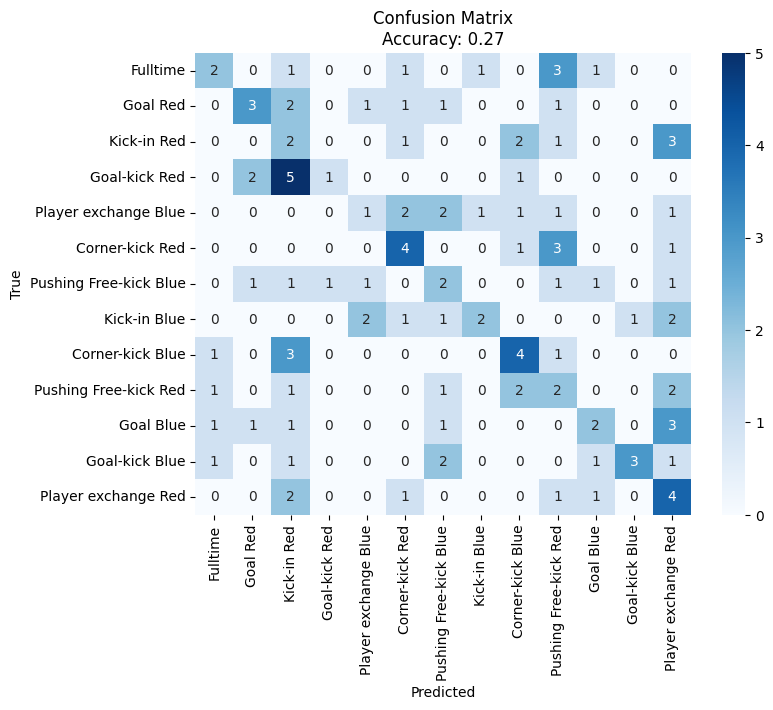

In [19]:
# let's test the model
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score


pose_keypoints_test = np.load('/content/drive/MyDrive/ModelFiles/Posenet/skeleton_data_valinao.npy')
labels_list_test = np.load('/content/drive/MyDrive/ModelFiles/Posenet/labels_posenet_valinao.npy')
for i, item in enumerate(labels_list_test):
    if item == 'corner-kick-red':
        labels_list_test[i] = 'Corner-kick Red'
    elif item == 'corner-kick-blue':
        labels_list_test[i] = 'Corner-kick Blue'
    elif item == 'goal-red':
        labels_list_test[i] = 'Goal Red'
    elif item == 'goal-blue':
        labels_list_test[i] = 'Goal Blue'
    elif item == 'goal-kick-red':
        labels_list_test[i] = 'Goal-kick Red'
    elif item == 'goal-kick-blue':
        labels_list_test[i] = 'Goal-kick Blue'
    elif item == 'kick-in-red':
        labels_list_test[i] = 'Kick-in Red'
    elif item == 'kick-in-blue':
        labels_list_test[i] = 'Kick-in Blue'
    elif item == 'player-exchange-red':
        labels_list_test[i] = 'Player exchange Red'
    elif item == 'player-exchange-blue':
        labels_list_test[i] = 'Player exchange Blue'
    elif item == 'pushing-free-kick-red':
        labels_list_test[i] = 'Pushing Free-kick Red'
    elif item == 'pushing-free-kick-blue':
        labels_list_test[i] = 'Pushing Free-kick Blue'
    elif item == 'full-time':
        labels_list_test[i] = 'Fulltime'

# define label_mapping once based on first dataset!!! important :)
label_mapping = {label: i for i, label in enumerate(set(labels_list_test))}

#reshape data
reshaped_data_test = reshape_data(pose_keypoints_test)
numerical_labels_test = np.array([label_mapping[label] for label in labels_list_test])

X_test = tf.convert_to_tensor(reshaped_data_test, dtype=tf.float32)
y_test = tf.keras.utils.to_categorical(numerical_labels_test)

#
indices = np.random.permutation(len(X_test))
indices_tensor = tf.convert_to_tensor(indices, dtype=tf.int32)
X_test = tf.gather(X_test, indices_tensor)
y_test = tf.gather(y_test, indices_tensor)

class_counts = tf.math.reduce_sum(y_test, axis=0)

# Print the number of datapoints per class
for i, count in enumerate(class_counts):
    print(f"Class {i}: {count}")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
print('pred', y_pred_classes)
print('true', y_true_classes)

# Create the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# Plot the confusion matrix with accuracy
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping, yticklabels=label_mapping)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}')
plt.show()